In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

## Different vectorizations

In [3]:
orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history[["order_id","product_id"]].sort_values(by='order_id')#.head(1000000)

In [4]:
consumptions = pd.merge(history_small, orders_small, on="order_id")[['user_id','product_id']]

In [5]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

,user_id,product_id,aisle_id,department_id
0,202279,33120,86,16
1,153404,33120,86,16
2,23750,33120,86,16
3,58707,33120,86,16
4,166654,33120,86,16


In [6]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

The greatest user id is 206209.


In [7]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

### A - Set of aisles with total number products bought in the aisle

In [8]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

The greatest aisle id is 134.


In [9]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

product_id
user_id aisle_id            
1       21                 8
        23                12
        24                 5
        45                 1
        53                 2

In [10]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [11]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

8.7% processed
17.4% processed
26.1% processed
34.8% processed
43.5% processed
52.2% processed
60.9% processed
69.6% processed
78.3% processed
87.0% processed
95.7% processed
Done !
8.8% processed
17.5% processed
26.3% processed
35.0% processed
43.8% processed
52.5% processed
61.3% processed
70.0% processed
78.8% processed
87.5% processed
96.3% processed
Done !


### B - Clustering and evaluation of the best number of clusters

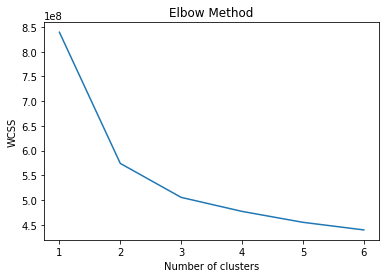

In [14]:
wcss=[]
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [13]:
from sklearn.cluster import KMeans

In [21]:
pickle.dump(user_matrix,open('matrix.p','wb'))